In [37]:
import pickle
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Embedding, Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

from utils import vectorize_stories

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
with open('data/train_qa.txt', 'rb') as f:
    train_data = pickle.load(f)

In [3]:
with open('data/test_qa.txt', 'rb') as f:
    test_data = pickle.load(f)

In [4]:
all_data = test_data + train_data
vocab = set()

for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

# Possible answers
vocab.add('no')
vocab.add('yes')

vocab_len = len(vocab) + 1 # Later on we will use keras pad sequences, so we need this margin

### Find the longest story and question

In [5]:
max_story_len = max([len(data[0]) for data in all_data])
max_story_len

156

In [6]:
# 1 is the index of the data story
max_question_len = max([len(data[1]) for data in all_data])
max_question_len

6

In [7]:
# We don't need filters for this
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [8]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

In [9]:
# Numerical version of the story texts (mapped indexes) -> each word to its matching numeric index
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [79]:
tokenizer.word_index

{'mary': 1,
 'kitchen': 2,
 'sandra': 3,
 'left': 4,
 'took': 5,
 'john': 6,
 'bedroom': 7,
 'yes': 8,
 'dropped': 9,
 'football': 10,
 'got': 11,
 'the': 12,
 'went': 13,
 'up': 14,
 'daniel': 15,
 'put': 16,
 'down': 17,
 '?': 18,
 'hallway': 19,
 'garden': 20,
 'picked': 21,
 'to': 22,
 'milk': 23,
 'in': 24,
 'moved': 25,
 'discarded': 26,
 'back': 27,
 'journeyed': 28,
 'is': 29,
 'there': 30,
 'grabbed': 31,
 'no': 32,
 '.': 33,
 'bathroom': 34,
 'office': 35,
 'apple': 36,
 'travelled': 37}

In [11]:
inputs_train, questions_train, answers_train = vectorize_stories(train_data, tokenizer.word_index, max_story_len, max_question_len)
inputs_test, questions_test, answers_test = vectorize_stories(test_data, tokenizer.word_index, max_story_len, max_question_len)

## DL Model

In [12]:
# The ',' is a Placeholder => shape=(max_story,len, batch_size), as we don't know yet the batch size
# It represents a 'None'
input_sequence = Input((max_story_len, ))
question = Input((max_question_len, ))

In [13]:
# Input encoders
vocab_size = len(vocab) + 1

# M - Outputs: (samples, story_maxlen, embedding_dim)
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
# Randomly turns off a % of neurons
input_encoder_m.add(Dropout(0.3))

# C - Outputs: (samples, story_maxlen, max_question_len)
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

In [14]:
# Question encoder - Outputs: (samples, question_maxlen, embedding_dim)
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                              output_dim=64,
                              input_length=max_question_len))
question_encoder.add(Dropout(0.3))

c:\Users\jtorn\Escritorio\Dev\CODE\ML&DL\chatbot\venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
# Pass data into encoders
input_encoded_m = input_encoder_m(input_sequence)

input_encoded_c = input_encoder_c(input_sequence)

question_encoded = question_encoder(question)

In [16]:
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
# Implement activation softmax
match = Activation('softmax')(match)

In [17]:
response = add([match, input_encoded_c])
# Reorder dimension
response = Permute((2,1))(response)

In [23]:
# Output layer
answer = concatenate([response, question_encoded])

answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer)
# Output layer: (samples, vocab_size) YES/NO
answer = Dense(vocab_size)(answer)

answer = Activation("softmax")(answer)

In [24]:
# Create model
model = Model([input_sequence, question], answer)

In [26]:
# Across entire vocabulay, so its a crossentropy categorical problem (probabilities over yes/no)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 156)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 156, 64)   │      2,432 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 6, 64)     │      2,432 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 156, 6)    │          0 │ sequential[0][0], │
│                     │                   │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 156, 6)    │          0 │ dot[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 156, 6)    │        228 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 156, 6)    │          0 │ activation[0][0], │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 6, 156)    │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 6, 220)    │          0 │ permute[0][0],    │
│ (Concatenate)       │                   │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 32)        │     32,384 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 38)        │      1,254 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 38)        │          0 │ dense_1[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,730 (151.29 KB)

 Trainable params: 38,730 (151.29 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit([inputs_train, questions_train],
                    answers_train,
                    batch_size=32,
                    epochs=100,
                    # Validation data
                    validation_data=([inputs_test, questions_test], answers_test))

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4846 - loss: 1.2123 - val_accuracy: 0.4970 - val_loss: 0.6969
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4906 - loss: 0.7102 - val_accuracy: 0.4970 - val_loss: 0.6950
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5084 - loss: 0.6980 - val_accuracy: 0.5030 - val_loss: 0.6940
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5067 - loss: 0.6960 - val_accuracy: 0.4970 - val_loss: 0.6934
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5056 - loss: 0.6955 - val_accuracy: 0.5030 - val_loss: 0.6953
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4951 - loss: 0.6957 - val_accuracy: 0.5030 - val_loss: 0.6932
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5099 - loss: 0.6945 - val_accuracy: 0.4970 - val_loss: 0.6938
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5092 - loss: 0.6952 - val_accu

### Model and tokenizer saving

In [1]:
import json

model.save('saved_model/chatbot_100_epochs.keras')
with open("saved_model/tokenizer.json", "w") as f:
    data = {
        "word_index": tokenizer.word_index,
        "max_story_len": max_story_len,
        "max_question_len": max_question_len
    }

    json.dump(data, f)

NameError: name 'model' is not defined

## Plotting results

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


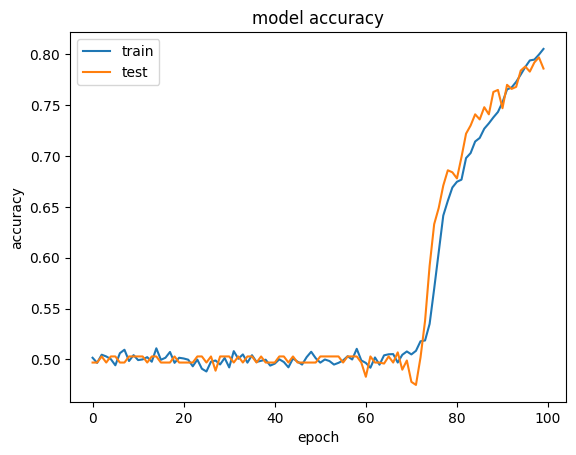

In [36]:


print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

## Inference example with test data

In [50]:
pred_results = model.predict([inputs_test, questions_test])

pred_question = test_data[0][1]
result = np.argmax(pred_results[0])
for key, val in tokenizer.word_index.items():
    if val == result:
        result_text = key


print(f"{' '.join(pred_question)}: {result_text}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Is John in the kitchen ?: no


In [51]:
# These are the only words the model understands (its vocabulay) =>
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [70]:
# We need to keep space between puntuactions as the data used to train was in this format
my_story = "John left the kitchen . Sandra dropped the football in the garden ."

my_story.split() # Same format as train data

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [71]:
my_question = "Is the football in the garden ?"
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [66]:
my_correct_answer = "yes"

In [72]:
my_data = [(my_story.split(), my_question.split(), my_correct_answer)] # Story, question and answer
my_data

[(['John',
   'left',
   'the',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'the',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'the', 'football', 'in', 'the', 'garden', '?'],
  'yes')]

In [69]:
my_story_vec, my_question_vec, my_answer_vec = vectorize_stories(my_data, tokenizer.word_index, max_story_len, max_question_len)
my_story_vec

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,
         4, 12,  2, 33,  3,  9, 12, 10, 24, 12, 20, 33]])

In [75]:
pred_results = model.predict([my_story_vec, my_question_vec])

result = np.argmax(pred_results[0])
for key, val in tokenizer.word_index.items():
    if val == result:
        result_text = key


print(f"Predicted with a {pred_results[0][result]} certainty")
print(f"{my_question}: {result_text}")
print(f"Was correct?: {result_text == my_correct_answer}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predicted with a 0.679633617401123 certainty
Is the football in the garden ?: yes
Was correct?: True
